# Calculating sea ice area and extent

> history \| Create August 2023 <br/>

<a href="https://polarwatch.noaa.gov/" target="_blank">NOAA PolarWatch</a> distributes gridded and tabular oceanographic data for polar regions. Many of the PolarWatch data products include sea ice related satellite data. Sea ice extent and sea ice area describe the area of ice coverage at a given time and play an important role as an environemntal indicator in climate research. 


In this exercise, we will learn to calculate sea ice area and extent using sea ice concentration data and grid cell area data.  Please visit The <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">NSIDC website</a> for the detailed description of the calculation. 

**The exercise demonstrates the following techniques:**
-   Downloading and saving a netcdf file from PolarWatch ERDDAP data server
-   Accessing satellite data and metadata in polar stereographic projection
-   Downloading and using grid cell area file of polar stereographic projection
-   Computing sea ice area and extent using sea ice concentration data
-   Plotting sea ice area and extent

**Datasets used:**
-   sea ice concentration from the northern hemisphere 

**Python packages used:**
-   xarray (reading and analyzing data)
-   pyproj (reprojection)
-   cartopy (mapping projection)
-   matplotlib (mapping)
-   numpy (data analysis, manipulation)



### Reference
- <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">What's the difference between Sea ice area and extent?</a>
- <a href="https://nsidc.org/arcticseaicenews/">NSIDC Arctic Sea Ice News & Analysis</a>
- <a href="https://www.climate.gov/news-features/understanding-climate/understanding-climate-antarctic-sea-ice-extent">Climate.gov Understanding Climate: sea ice extent</a>




## Import packages

In [12]:
import urllib.request
import pyproj
import xarray as xr
import numpy as np
import pyproj
from pyproj import CRS
from pyproj import Transformer as transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


## Arctic Sea Ice Concentration Data

To demonstrate sea ice extent estimation, NSIDC Sea Ice Concentration data from passive microwave sensors will be used.
This dataset includes sea ice concentration data from the northern hemisphere, and is produced by the NOAA/NSIDC and annually processed, using the Climate Data Record algorithm.  The resolution is 25km, meaning each grid in this data set represents a value that covers a 25km by 25km area.  


**Data**

*Sea Ice Concentration*, NOAA/NSIDC Climate Data Record V4, Northern Hemisphere, 25km, Science Quality, 1978-2022, Monthly



**Userful links**

-   <a href="https://nsidc.org/data/g02202/versions/4" target="_blank">NSIDC Data Product Description</a>
-   <a href="https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf" target="_blank">NSIDC Data Product User Guide (pdf)</a>
-   <a href="https://polarwatch.noaa.gov/catalog/ice-sq-nh-nsidc-cdr-v4/preview/?dataset=daily&var=cdr_seaice_conc&time_min=2022-05-31T00:00:00Z&time_max=2022-05-31T00:00:00Z&proj=epsg3413&colorBar=KT_ice|||0|1|" target="_blank">NOAA PolarWatch Data Product Page (download, preview)</a>




### Sending data request to PolarWatch ERDDAP server

ERDDAP URL can be constructed to customize the dataset to be received. 

```
https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]"
```

| Name   | Value| Description |
| ---:        |    :----   |          :--- |
| **ERDDAP URL**    |    https://polarwatch.noaa.gov/erddap/griddap  | ERDDAP URL for gridded datasets
| **Dataset ID** | nsidcG02202v4nhmday   | Unique ID for dataset from PolarWatch ERDDAP
| **File format**  | .nc        | netCDF and there are many other available file formats|
| **Variable name**   | cdr_seaice_conc_monthly        | list of variables from the dataset 
| **Time coverage**   | [(2021-01-01T00:00:00Z):1:(2021--01-01T00:00:00Z)]      |  Temporal date range (2021-01-01)
| **Spatial coverage**   | [(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]  |  spatial range 

 



In [13]:
url="https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2022-12-01T00:00:00Z):1:(2022-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]"
urllib.request.urlretrieve(url, "sic.nc")

('sic.nc', <http.client.HTTPMessage at 0x142b3f190>)

In [14]:
# open and assign data from the file to a variable ds using xarray
ds = xr.open_dataset("sic.nc")


### Grid area data of polar stereographic projection

While the resolution is set at 25km (25km by 25km grid), the actual area of the grid depends on the projection. The NSIDC publishes the actual grid area of polar stereographic projection of different resolutions in a netCDF file format.  The file for this exercise can be found in the exercise resources folder.

Data download: https://nsidc.org/data/nsidc-0771/versions/1


In [15]:
grid_area = xr.open_dataset("../resources/NSIDC0771_CellArea_PS_N25km_v1.0.nc")

In [16]:
grid_area

<xarray.Dataset>
Dimensions:    (x: 304, y: 448)
Coordinates:
  * x          (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y          (y) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
Data variables:
    crs        int32 ...
    cell_area  (y, x) float64 ...
Attributes: (12/38)
    title:                     Polar Stereo Ancillary Grid Information
    summary:                   This data set provides the total on-Earth surf...
    id:                        10.5067/N6INPBT8Y104
    metadata_link:             https://doi.org/10.5067/N6INPBT8Y104
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    ...                        ...
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           1.0

In [17]:
# subsetting grid area to match dataset

xgrid = ds['xgrid'].values
ygrid = ds['ygrid'].values

xmax, xmin, ymax, ymin = np.max(xgrid), np.min(xgrid), np.max(ygrid), np.min(ygrid)

sub_area = grid_area.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

### Adding area to the DataSet

In [18]:
# add grid area to the dataset
cell_area = sub_area.cell_area.values
ds['area'] = (('ygrid', 'xgrid'), cell_area)

### Calculating Sea ice area and extent

In [19]:
# subset the dataset to exclude flag values
seaice_ds = ds.where(ds.cdr_seaice_conc_monthly <= 1)

icearea = seaice_ds.area * seaice_ds.cdr_seaice_conc_monthly[0][:]
tot_icearea = np.sum(icearea) /1000000 # from m^2 to km^2
print("Sea Ice Area (km^2): ", tot_icearea)

ext = seaice_ds.area * xr.where(seaice_ds.cdr_seaice_conc_monthly[0][:] < 0.15, 0, 1)
extent = np.sum(ext)/1000000 # from m^2 to km^2
print("Sea Ice Extent (km^2):", extent)

Sea Ice Area (km^2):  <xarray.DataArray ()>
array(11105290.18410407)
Sea Ice Extent (km^2): <xarray.DataArray ()>
array(12391285.84189521)


## Working with 12 months time series

The next exercise is to download 12 months of sea ice concentration data and compute sea ice area and extent for each month.

The modified url :

<code>url="https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2021-01-01T00:00:00Z):1:( **2021-12-01T00:00:00Z** )][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]</code>

In [20]:
# get 12 months data
url="https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]"
urllib.request.urlretrieve(url, "sic12.nc")

# open and assign data from the file to a variable ds using xarray
ds = xr.open_dataset("sic12.nc")

# add grid area to the dataset
cell_area = sub_area.cell_area.values
ds['area'] = (('ygrid', 'xgrid'), cell_area)

# subset the dataset to exclude flag values
seaice_ds = ds.where(ds.cdr_seaice_conc_monthly <= 1)

icearea = seaice_ds.area * seaice_ds.cdr_seaice_conc_monthly
tot_icearea = np.sum(icearea)
tot_icearea

ext = seaice_ds.area * xr.where(seaice_ds.cdr_seaice_conc_monthly < 0.15, 0, 1)
extent = ext.sum(dim=['xgrid', 'ygrid']) / 1000000

icea_month = icearea.sum(dim=['xgrid', 'ygrid']) / 1000000
icea_month


<xarray.DataArray (time: 12)>
array([12573588.20885628, 13460762.97339725, 13698532.12620623,
       12824438.10910926, 11590415.95262193,  9371027.38969998,
        6722524.61938882,  4810926.44460557,  4353318.12229081,
        6304612.89786943,  9270005.76585693, 11408019.72706273])
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01

## Plot monthly sea ice area and extent

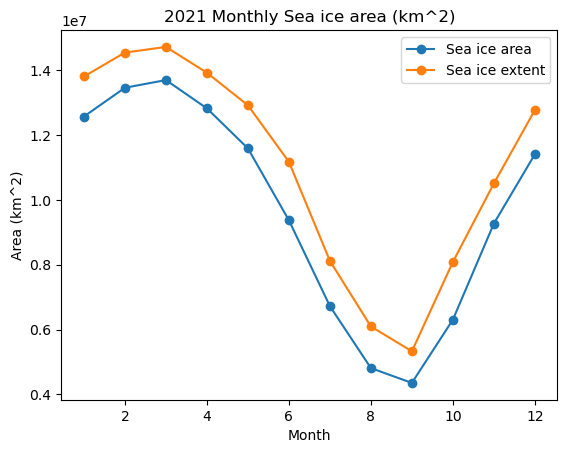

In [21]:

fig, ax = plt.subplots()

# Plot the data as a line
ax.plot(list(range(1,13)),icea_month , label='Sea ice area', marker='o', linestyle='-')
ax.plot(list(range(1,13)),extent , label='Sea ice extent', marker='o', linestyle='-')


# Add a title and labels
ax.set_title('2021 Monthly Sea ice area (km^2)')
ax.set_xlabel('Month')
ax.set_ylabel('Area (km^2)')

# Display the legend
ax.legend()

# Show the plot
plt.show()